In [475]:
import pandas as pd
import numpy as np
import sklearn
import matplotlib.pyplot as plt
import warnings
import lightgbm as lgb
from tqdm import tqdm
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score

warnings.filterwarnings("ignore")

%matplotlib inline

train_set_csv = 'data/train_set.csv'
test_set_csv = 'data/test_set.csv'

In [476]:
train_set = pd.read_csv(train_set_csv)
test_set = pd.read_csv(test_set_csv)

print(train_set.columns)
train_set.head()

Index(['ID', 'age', 'job', 'marital', 'education', 'default', 'balance',
       'housing', 'loan', 'contact', 'day', 'month', 'duration', 'campaign',
       'pdays', 'previous', 'poutcome', 'y'],
      dtype='object')


,ID,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,1,43,management,married,tertiary,no,291,yes,no,unknown,9,may,150,2,-1,0,unknown,0
1,2,42,technician,divorced,primary,no,5076,yes,no,cellular,7,apr,99,1,251,2,other,0
2,3,47,admin.,married,secondary,no,104,yes,yes,cellular,14,jul,77,2,-1,0,unknown,0
3,4,28,management,single,secondary,no,-994,yes,yes,cellular,18,jul,174,2,-1,0,unknown,0
4,5,42,technician,divorced,secondary,no,2974,yes,no,unknown,21,may,187,5,-1,0,unknown,0


In [477]:
# 输入处理 one-hot,blance 取log
import sklearn.preprocessing as preprocessing

train_set['is_train'] = 1
test_set['is_train'] = 0
combine_df = pd.concat([train_set,test_set])

month_map = {
    'jan': 1,
    'feb': 2,
    'mar': 3,
    'apr': 4, 
    'may': 5,
    'jun': 6,
    'jul': 7,
    'aug': 8,
    'sep': 9,
    'oct': 10,
    'nov': 11,
    'dec': 12,
}
combine_df['month'] = combine_df['month'].apply(lambda x : int(month_map[x]))
combine_df['month'] = combine_df['month'].astype(int)
combine_df['quater_of_year'] = combine_df['month'].apply(lambda x : x//3)  # 季度
combine_df['quater_of_month'] = combine_df['day'].apply(lambda x : x//7)  # 周
combine_df['balance_positive'] = combine_df['balance'].apply(lambda x : 0 if x < 0 else 1) # 是否有存款
combine_df['month_mul_day'] = combine_df['month'] * 30 + combine_df['day']
combine_df['age_mod_30'] = combine_df['age'].apply(lambda x : x//30)


In [478]:
def feature_count(data, features):
    feature_name = 'count'
    for i in features:
        feature_name += '_' + i
    temp = data.groupby(features).size().reset_index().rename(columns={0: feature_name})
    data = data.merge(temp, 'left', on=features)
    return data,feature_name

In [479]:
def get_new_columns(name,aggs):
    l=[]
    for k in aggs.keys():
        for agg in aggs[k]:
            if str(type(agg))=="<class 'function'>":
                l.append(name + '_' + k + '_' + 'other')
            else:
                l.append(name + '_' + k + '_' + agg)
    return l

In [480]:
# # 客户的统计特征

# 统计 job，ma
# 分组统计f_a的f_b 数值，并作为新特征
f_a = ['job','marital','education']#,'default','housing','loan']
f_b = ['balance','duration']

aggs = {}
for b in f_b:
    aggs[b] = ['mean','max','min','std']
    
    
#ll = []
for d in f_a:
    for b in f_b:
        temp=combine_df.groupby(d, as_index=False).agg(aggs)
        temp.columns=[d]+get_new_columns(d,aggs)
        combine_df=pd.merge(combine_df,temp,on=d,how='left')


In [481]:
# 日期交叉统计特征
ll=[]
for f in['campaign', 'contact','default','education','housing','job','loan','marital','poutcome']:
    combine_df,_=feature_count(combine_df,['day','month',f])
    ll.append(_)

In [482]:
le = preprocessing.LabelEncoder()
labels = ['job','marital', 'education', 'default', 'housing', 'loan', 'contact', 'poutcome']
for label in labels:
    le.fit(combine_df[label])
    combine_df[label] = le.transform(combine_df[label])

In [483]:
train_df = combine_df[combine_df['is_train']==1].drop(labels=['is_train', 'ID'],axis=1)
test_df = combine_df[combine_df['is_train']==0].drop(labels=['is_train','y'],axis=1)
print(train_df.columns)

feature_names = []
categorical_feature = labels + ['month', 'quater_of_month','age_mod_30']
for column in train_df.columns:
    if column != 'y':
        feature_names.append(column)

train_df.head()

Index(['age', 'balance', 'campaign', 'contact', 'day', 'default', 'duration',
       'education', 'housing', 'job', 'loan', 'marital', 'month', 'pdays',
       'poutcome', 'previous', 'y', 'quater_of_year', 'quater_of_month',
       'balance_positive', 'month_mul_day', 'age_mod_30', 'job_balance_mean_x',
       'job_balance_max_x', 'job_balance_min_x', 'job_balance_std_x',
       'job_duration_mean_x', 'job_duration_max_x', 'job_duration_min_x',
       'job_duration_std_x', 'job_balance_mean_y', 'job_balance_max_y',
       'job_balance_min_y', 'job_balance_std_y', 'job_duration_mean_y',
       'job_duration_max_y', 'job_duration_min_y', 'job_duration_std_y',
       'marital_balance_mean_x', 'marital_balance_max_x',
       'marital_balance_min_x', 'marital_balance_std_x',
       'marital_duration_mean_x', 'marital_duration_max_x',
       'marital_duration_min_x', 'marital_duration_std_x',
       'marital_balance_mean_y', 'marital_balance_max_y',
       'marital_balance_min_y', 'marital_

,age,balance,campaign,contact,day,default,duration,education,housing,job,...,education_duration_std_y,count_day_month_campaign,count_day_month_contact,count_day_month_default,count_day_month_education,count_day_month_housing,count_day_month_job,count_day_month_loan,count_day_month_marital,count_day_month_poutcome
0,43,291,2,2,9,0,150,2,1,4,...,262.404096,112,338,326,67,303,46,292,180,338
1,42,5076,1,0,7,0,99,0,1,9,...,261.806121,41,68,71,9,54,12,62,9,7
2,47,104,2,0,14,0,77,1,1,0,...,249.412365,78,204,230,147,138,30,64,166,235
3,28,-994,2,0,18,0,174,1,1,4,...,249.412365,49,194,194,110,130,60,72,53,206
4,42,2974,5,2,21,0,187,1,1,9,...,249.412365,15,357,361,213,326,63,313,24,358


In [484]:
print(len(feature_names))
categorical_feature

78


['job',
 'marital',
 'education',
 'default',
 'housing',
 'loan',
 'contact',
 'poutcome',
 'month',
 'quater_of_month',
 'age_mod_30']

In [485]:
# 划分数据集 验证集

param = {'num_leaves': 31,
         'min_data_in_leaf': 30, 
         'objective':'binary',
         'max_depth': -1,
         'learning_rate': 0.01,
         "min_child_samples": 20,
         "boosting": "gbdt",
         "feature_fraction": 0.9,
         "bagging_freq": 1,
         "bagging_fraction": 0.9 ,
         "bagging_seed": 11,
         "metric": 'auc',
         "lambda_l1": 0.1,
         "verbosity": -1,
         "nthread": 12,
         "random_state": 42}

all_preds = []
all_auc = []

splits = StratifiedKFold(n_splits=5, 
                         shuffle=True, 
                         random_state=42).split(train_df[feature_names], train_df['y'])

x_train = train_df[feature_names].values
y_train = train_df['y'].values

train_pred = np.zeros(len(x_train))
feature_importance_df = pd.DataFrame()

for i, (train_idx, val_idx) in enumerate(splits):
    train_data = lgb.Dataset(data=x_train[train_idx], 
                             label=y_train[train_idx], 
                             feature_name = feature_names, 
                             categorical_feature=categorical_feature)
    val_data = lgb.Dataset(data=x_train[val_idx], 
                           label=y_train[val_idx],
                           feature_name = feature_names, 
                           categorical_feature=categorical_feature, reference = train_data)
    
    num_round = 10000
    bst = lgb.train(param, 
                    train_data, 
                    num_round, 
                    valid_sets=[val_data], 
                    verbose_eval=100,
                    early_stopping_rounds=100)        
    
    y_pred = bst.predict(data=test_df[feature_names],num_iteration= bst.best_iteration)
    train_pred[val_idx] = bst.predict(data=x_train[val_idx], num_iteration= bst.best_iteration)
    all_auc.append(bst.best_score['valid_0']['auc'])
    all_preds.append(y_pred)          
    
    fold_importance_df = pd.DataFrame()
    fold_importance_df["Feature"] = feature_names
    fold_importance_df["importance"] = bst.feature_importance()
    fold_importance_df["fold"] = i + 1
    feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
    

Training until validation scores don't improve for 100 rounds.
[100]	valid_0's auc: 0.933909
[200]	valid_0's auc: 0.934654
[300]	valid_0's auc: 0.935384
[400]	valid_0's auc: 0.936134
[500]	valid_0's auc: 0.936726
[600]	valid_0's auc: 0.93684
[700]	valid_0's auc: 0.936894
[800]	valid_0's auc: 0.936775
Early stopping, best iteration is:
[726]	valid_0's auc: 0.936958
Training until validation scores don't improve for 100 rounds.
[100]	valid_0's auc: 0.93043
[200]	valid_0's auc: 0.933565
[300]	valid_0's auc: 0.935114
[400]	valid_0's auc: 0.936023
[500]	valid_0's auc: 0.936502
[600]	valid_0's auc: 0.93669
Early stopping, best iteration is:
[578]	valid_0's auc: 0.936697
Training until validation scores don't improve for 100 rounds.
[100]	valid_0's auc: 0.939027
[200]	valid_0's auc: 0.943027
[300]	valid_0's auc: 0.944367
[400]	valid_0's auc: 0.94529
[500]	valid_0's auc: 0.945833
[600]	valid_0's auc: 0.945997
[700]	valid_0's auc: 0.94613
[800]	valid_0's auc: 0.946047
Early stopping, best itera

In [487]:
roc_auc_score(y_train, train_pred)

0.9415011448707957

In [488]:
y_pred = np.mean(all_preds, axis=0)

In [489]:
submissons = pd.DataFrame(data=zip(test_df['ID'], y_pred), columns=["ID", "pred"])
submissons.to_csv('lgb_5_fold.csv', index=False)

In [490]:
submissons.head()

,ID,pred
0,25318,0.036651
1,25319,0.002590
2,25320,0.006290
3,25321,0.700355
4,25322,0.021461


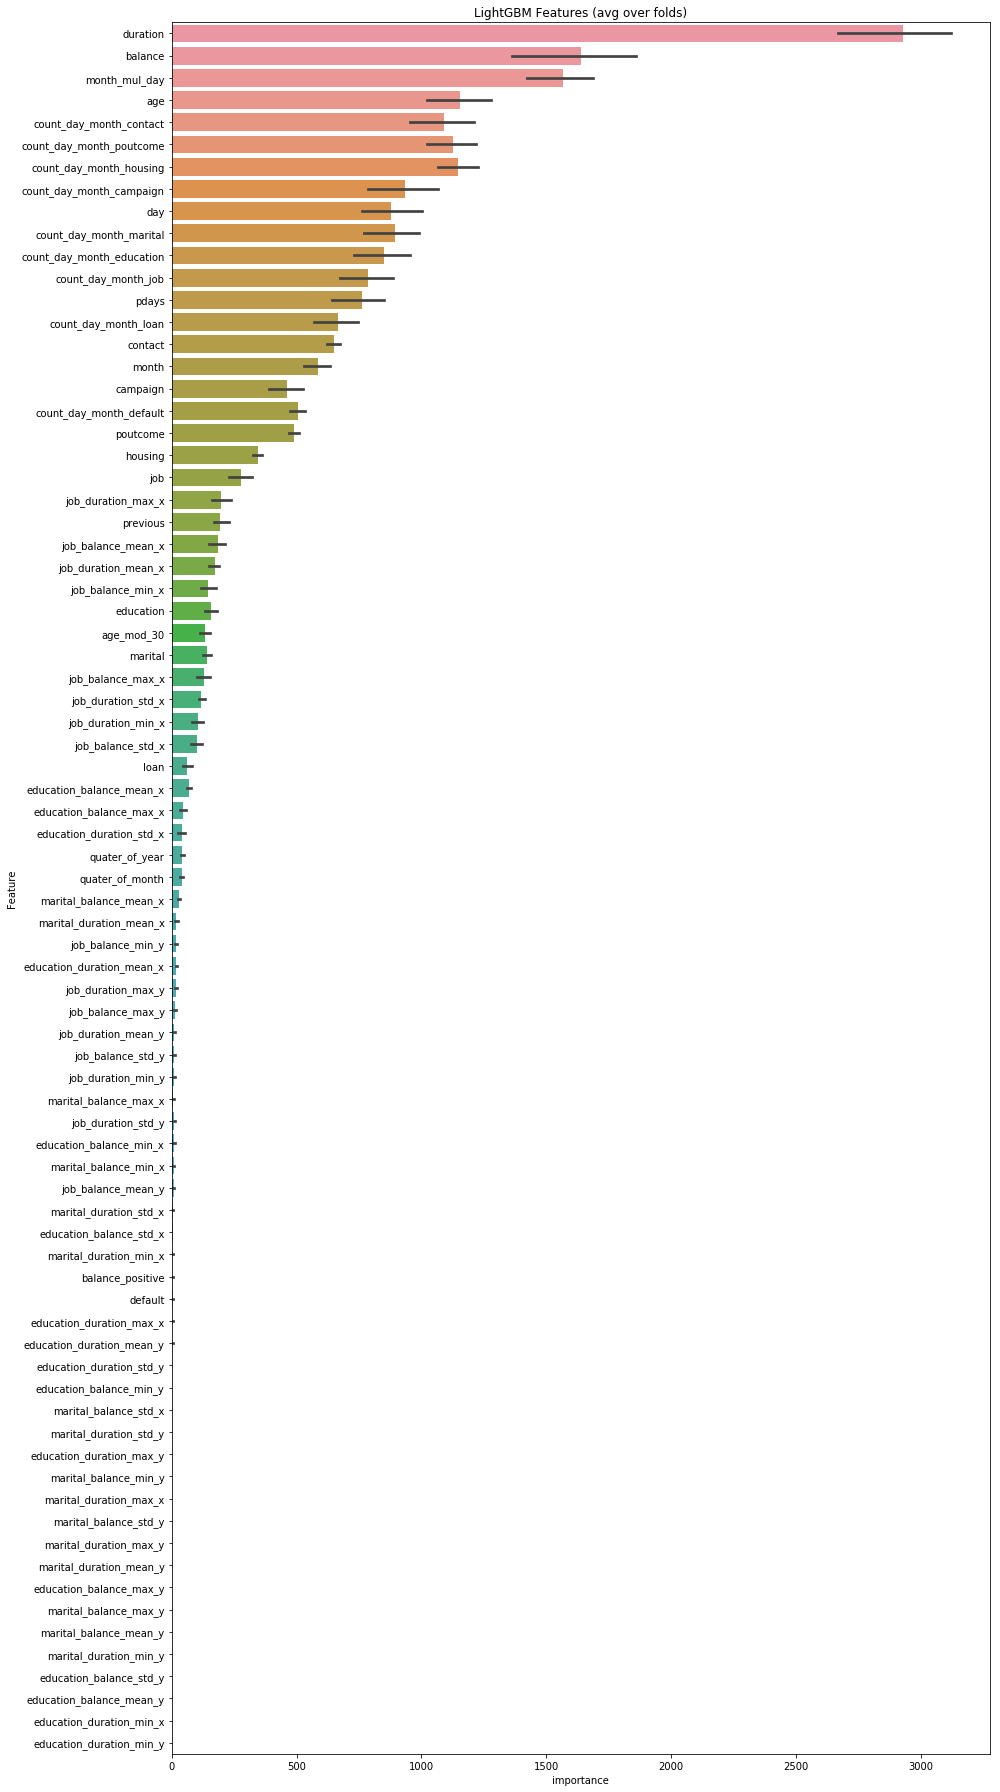

In [491]:
import seaborn as sns
import matplotlib.pyplot as plt

cols = (feature_importance_df[["Feature", "importance"]]
        .groupby("Feature")
        .mean()
        .sort_values(by="importance", ascending=False)[:500].index)

best_features = feature_importance_df.loc[feature_importance_df.Feature.isin(cols)]

plt.figure(figsize=(14,25))
sns.barplot(x="importance",
            y="Feature",
            data=best_features.sort_values(by="importance",
                                           ascending=False))
plt.title('LightGBM Features (avg over folds)')
plt.tight_layout()